In [1]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer
from massspecgym.tools.io import load_embeddings
from massspecgym.tools.data import get_embedding_for_node

import json
import os
from rdkit import Chem
from rdkit import RDLogger
import pandas as pd
import numpy as np
from collections import defaultdict, deque
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from matplotlib.colors import Normalize
from matplotlib import cm

# Suppress RDKit warnings for cleaner output
RDLogger.DisableLog('rdApp.*')


## Local definition of functions

In [2]:
def create_classyfire_df(json_path):
    """
    Create a pandas DataFrame from the ClassyFire JSON results.
    
    Parameters:
        json_path (str): Path to the JSON classification results.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['smiles', 'canonical_smiles', 'class', 'subclass', 'kingdom', 'superclass'].
    """
    # Load the JSON data
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    processed_records = []
    
    for record in data:
        # Extract the original SMILES
        smiles = record.get('smiles', None)
        
        # Get original SMILES send for classification
        original_canonized_smiles = record.get('original_canonized_smiles', None)
        
        # Extract classification fields safely
        classification = {}
        for field in ['kingdom', 'superclass', 'class', 'subclass']:
            field_data = record.get(field, {})
            classification[field] = field_data.get('name') if isinstance(field_data, dict) else None
        
        # Create a dictionary for the current record
        processed_record = {
            'smiles': smiles,
            'original_canonized_smiles': original_canonized_smiles,
            'kingdom': classification['kingdom'],
            'superclass': classification['superclass'],
            'class': classification['class'],
            'subclass': classification['subclass']
        }
        
        processed_records.append(processed_record)
    classyfire_df = pd.DataFrame(processed_records)
    
    return classyfire_df

def analyze_classyfire_df(classyfire_df, canonical_msn_map):
    """
    Analyze the ClassyFire DataFrame to determine matched and unmatched SMILES,
    ensure consistency among duplicate SMILES, and print statistics.

    Parameters:
        classyfire_df (pd.DataFrame): DataFrame with columns ['smiles', 'original_canonized_smiles', 'class', 'subclass', 'kingdom', 'superclass'].
        canonical_msn_map (dict): Mapping of original SMILES to their canonical forms.

    Returns:
        pd.DataFrame: Reduced DataFrame with unique canonical SMILES and their attributes.
    """
    # Calculate Matching Statistics
    total_unique = len(canonical_msn_map)
    match_count = 0
    unmatch_count = 0
    invalid_count = 0

    json_canonical_set = set(classyfire_df['original_canonized_smiles'].dropna().unique())

    for original_smi, canonical_smi in canonical_msn_map.items():
        if canonical_smi is None:
            invalid_count += 1
        elif canonical_smi in json_canonical_set:
            match_count += 1
        else:
            unmatch_count += 1

    print("\n=== Matching Results ===")
    print(f"Total unique SMILES in your dataset: {total_unique}")
    print(f"Matched SMILES: {match_count}")
    print(f"Unmatched SMILES: {unmatch_count}")
    print(f"Invalid SMILES: {invalid_count}")

    # Reduce the DataFrame to unique canonical_smiles
    # Keep only matched SMILES
    matched_df = classyfire_df[classyfire_df['original_canonized_smiles'].isin(json_canonical_set)].copy()

    # Drop duplicates based on canonical_smiles, keeping the first occurrence
    unique_classyfire_df = matched_df.drop_duplicates(subset=['original_canonized_smiles']).copy()

    # Identify duplicate SMILES in classyfire_df
    duplicates = classyfire_df[classyfire_df.duplicated(subset=['smiles'], keep=False)]

    inconsistent = []

    # Group by 'smiles' and check for consistency
    for smi, group in duplicates.groupby('smiles'):
        # Check if all attributes are the same within the group
        attributes = group[['original_canonized_smiles', 'class', 'subclass', 'kingdom', 'superclass']]
        if attributes.nunique().max() > 1:
            inconsistent.append(smi)

    # Print Consistency Results
    if inconsistent:
        print(f"\nNumber of SMILES with inconsistent attributes: {len(inconsistent)}")
        print("Example of inconsistent SMILES with differing attributes:")
        example_smi = inconsistent[0]
        example_group = duplicates[duplicates['smiles'] == example_smi]
        print(example_group)
    else:
        print("\nAll duplicate SMILES have consistent attributes.")

    print("\n=== Comprehensive Statistics ===")
    print(f"Total unique canonical SMILES: {unique_classyfire_df['original_canonized_smiles'].nunique()}")
    print(f"Total unique SMILES: {classyfire_df['smiles'].nunique()}")

    # Return the Reduced DataFrame
    return unique_classyfire_df

def canonicalize_smiles(smiles):
    """
    Canonicalize a SMILES string using RDKit.
    
    Parameters:
        smiles (str): The SMILES string to canonicalize.
    
    Returns:
        str or None: The canonical SMILES string, or None if invalid.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        else:
            return None
    except:
        return None
    
def load_unique_smiles(smiles_list):
    """
    Extract unique SMILES from the dataset and canonicalize them.
    
    Parameters:
        smiles_list (list of smiles): Your dataset containing a 'smiles' column.
    
    Returns:
        dict: Mapping of original SMILES to their canonical forms.
    """

    canonical_map = {}
    for smi in smiles_list:
        canonical = canonicalize_smiles(smi)
        canonical_map[smi] = canonical
    return canonical_map

def print_unique_counts(df, classification_level):
    """
    Print the number of unique values for a given classification level.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        classification_level (str): One of ['kingdom', 'superclass', 'class', 'subclass'].

    Returns:
        None
    """
    if classification_level not in ['kingdom', 'superclass', 'class', 'subclass']:
        print(f"Invalid classification level: {classification_level}")
        return
    
    unique_count = df[classification_level].nunique()
    print(f"Total unique values for '{classification_level}': {unique_count}")
    
def plot_class_distribution(df, classification_level, top_n=50, output_svg=False):
    """
    Plot the distribution of a classification level across different folds.

    Parameters:
        df (pd.DataFrame): Merged DataFrame containing classification and fold information.
        classification_level (str): One of ['kingdom', 'superclass', 'class', 'subclass'].
        top_n (int): Number of top classes to display individually; others are grouped as 'Other'.
        output_svg (bool): Whether to save the histogram as an SVG file.

    Returns:
        None
    """
    if classification_level not in ['kingdom', 'superclass', 'class', 'subclass']:
        print(f"Invalid classification level: {classification_level}")
        return

    # Calculate value counts
    cls_vc = df[classification_level].value_counts()

    # Select top_n classes
    top_classes = cls_vc.head(top_n).index

    # Replace classes not in top_n with 'Other'
    df_top = df.copy()
    df_top.loc[~df_top[classification_level].isin(top_classes), classification_level] = f'Other ({df_top[classification_level].nunique() - top_n} classes)'

    # Sort the DataFrame based on the frequency of classes
    df_top = df_top.sort_values(classification_level, key=lambda x: -x.map(cls_vc))

    # Replace 'fold' values with more readable labels
    df_top['Fold'] = df_top['fold'].replace({'train': 'Training', 'val': 'Validation', 'test': 'Testing'})

    # Define the desired reverse order for the folds (Testing first, Validation, Training)
    reverse_fold_order = ['Training', 'Validation', 'Testing']

    # Convert 'Fold' to a categorical type with the specified order
    df_top['Fold'] = pd.Categorical(df_top['Fold'], categories=reverse_fold_order, ordered=True)

    df_top = df_top.rename(columns={classification_level: 'Chemical class'})

    print(f"\nValue counts for {classification_level}:")
    print(df_top['Chemical class'].value_counts().head(top_n))

    palette = sns.color_palette('Set2', n_colors=len(reverse_fold_order))
    fold_palette = dict(zip(reverse_fold_order, palette))

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 10))

    # Create the histogram
    sns.histplot(
        data=df_top,
        y='Chemical class',
        hue='Fold',
        multiple='stack',
        shrink=1,
        palette=fold_palette,  
        edgecolor='none',
        hue_order=reverse_fold_order  
    )

    plt.xlabel('Number of Unique Molecules')
    plt.ylabel('Chemical Class')
    plt.title(f'Distribution of {classification_level.capitalize()} Across Folds')

    custom_legend = [
        plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10, label=fold)
        for fold, color in fold_palette.items()
    ]

    plt.legend(handles=custom_legend, title='Fold', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    if output_svg:
        plt.savefig(f'{classification_level}_classes_hist.svg')
    plt.show()
    
def analyze_exclusive_classes(df, classification_level):
    """
    Identify and print exclusive classes and molecule counts per fold for a given classification level.

    Parameters:
        df (pd.DataFrame): Merged DataFrame containing classification and fold information.
        classification_level (str): One of ['kingdom', 'superclass', 'class', 'subclass'].

    Returns:
        None
    """
    if classification_level not in ['kingdom', 'superclass', 'class', 'subclass']:
        print(f"Invalid classification level: {classification_level}")
        return

    # Group by classification and fold
    df_cls_folds = df.groupby([classification_level, 'fold'])['mol_freq'].count().sort_values(ascending=False)
    df_cls_folds = df_cls_folds.unstack().fillna(0).astype(int)

    # Ensure the folds are in the desired order
    if set(['train', 'val', 'test']).issubset(df_cls_folds.columns):
        df_cls_folds = df_cls_folds[['train', 'val', 'test']]
    else:
        # Adjust based on available folds
        available_folds = [fold for fold in ['train', 'val', 'test'] if fold in df_cls_folds.columns]
        df_cls_folds = df_cls_folds[available_folds]

    # Sort based on 'train' count
    if 'train' in df_cls_folds.columns:
        df_cls_folds = df_cls_folds.sort_values('train', ascending=False)
    elif 'val' in df_cls_folds.columns:
        df_cls_folds = df_cls_folds.sort_values('val', ascending=False)
    elif 'test' in df_cls_folds.columns:
        df_cls_folds = df_cls_folds.sort_values('test', ascending=False)

    # Print exclusive classes and molecule counts per fold
    folds = ['train', 'val', 'test']
    print(f"\n=== Exclusive Classes for {classification_level.capitalize()} ===")
    for f in folds:
        if f not in df_cls_folds.columns:
            continue  # Skip if fold is not present
        print('---', f.capitalize(), '---')
        folds_other = [x for x in folds if x != f]
        if not folds_other:
            print(f"No other folds to compare with for fold '{f}'.")
            continue
        # Create a mask where other folds have zero
        mask = (df_cls_folds[folds_other[0]] == 0)
        if len(folds_other) > 1:
            for other_fold in folds_other[1:]:
                mask &= (df_cls_folds[other_fold] == 0)
        df_only_f = df_cls_folds[mask]
        print('Num. exclusive classes:', len(df_only_f))
        print('Num. exclusive molecules:', df_only_f[f].sum())

## Analysis

In [3]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [4]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

featurizer = SpectrumFeaturizer(config, mode='torch')

In [5]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [6]:
all_smiles = msn_dataset.smiles

In [7]:
# Define the path to your JSON classification results
json_path = '/Users/macbook/CODE/PyClassyFire/data/results3/output.json'

# Create the DataFrame
classyfire_df = create_classyfire_df(json_path)

In [8]:
classyfire_df["original_canonized_smiles"].nunique()

13680

In [9]:
canonical_msn_map = load_unique_smiles(all_smiles)
total_unique = len(canonical_msn_map)
print(f"Total unique SMILES in your dataset: {total_unique}")

Total unique SMILES in your dataset: 13984


In [10]:
# Analyze the ClassyFire DataFrame
unique_classyfire_df = analyze_classyfire_df(classyfire_df, canonical_msn_map)


=== Matching Results ===
Total unique SMILES in your dataset: 13984
Matched SMILES: 13979
Unmatched SMILES: 5
Invalid SMILES: 0

All duplicate SMILES have consistent attributes.

=== Comprehensive Statistics ===
Total unique canonical SMILES: 13680
Total unique SMILES: 13680


In [13]:
root_nodes = msn_dataset.metadata[msn_dataset.metadata["ms_level"] == "2"].copy()
root_nodes['original_canonized_smiles'] = root_nodes['smiles'].apply(canonicalize_smiles)
root_nodes['original_canonized_smiles'].nunique()

13685

In [14]:
merged_df = pd.merge(root_nodes, unique_classyfire_df, on='original_canonized_smiles', how='inner')

In [15]:
# Perform analysis for each classification level
classification_levels = ['kingdom', 'superclass', 'class', 'subclass']

for classification in classification_levels:
    print(f"\n===== Analysis for {classification.capitalize()} =====")
    print_unique_counts(merged_df, classification)



===== Analysis for Kingdom =====
Total unique values for 'kingdom': 1

===== Analysis for Superclass =====
Total unique values for 'superclass': 16

===== Analysis for Class =====
Total unique values for 'class': 260

===== Analysis for Subclass =====
Total unique values for 'subclass': 395



Value counts for kingdom:
Chemical class
Organic compounds    16471
Name: count, dtype: int64


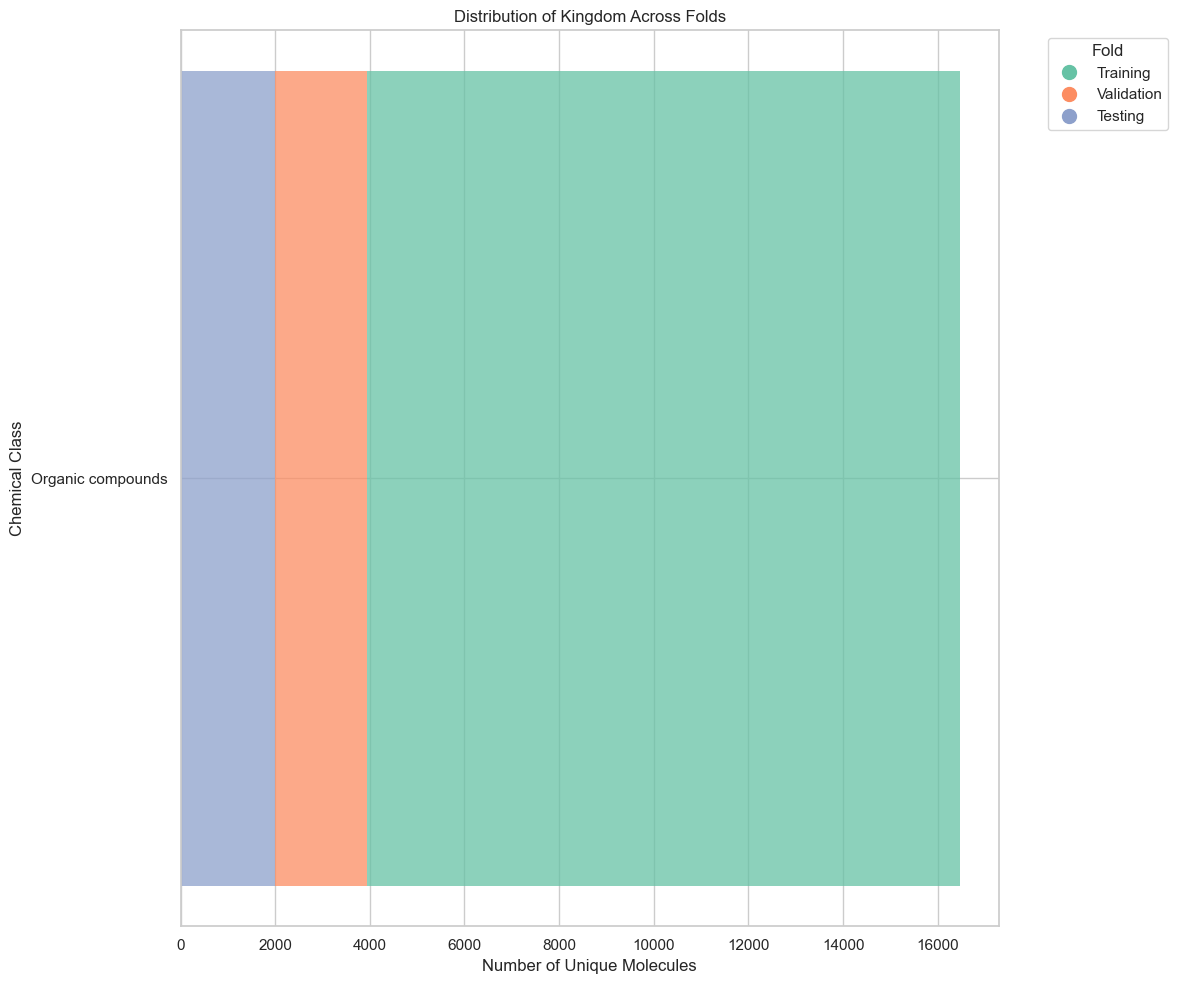

In [16]:
plot_class_distribution(merged_df, 'kingdom', top_n=50, output_svg=False)


Value counts for superclass:
Chemical class
Organoheterocyclic compounds                 6525
Benzenoids                                   3309
Organic acids and derivatives                1957
Lipids and lipid-like molecules              1693
Phenylpropanoids and polyketides             1395
Organic oxygen compounds                      675
Organic nitrogen compounds                    284
Alkaloids and derivatives                     217
Nucleosides, nucleotides, and analogues       148
Organosulfur compounds                        140
Lignans, neolignans and related compounds     103
Organic Polymers                               11
Hydrocarbon derivatives                         7
Organohalogen compounds                         3
Organophosphorus compounds                      2
Organic 1,3-dipolar compounds                   2
Name: count, dtype: int64


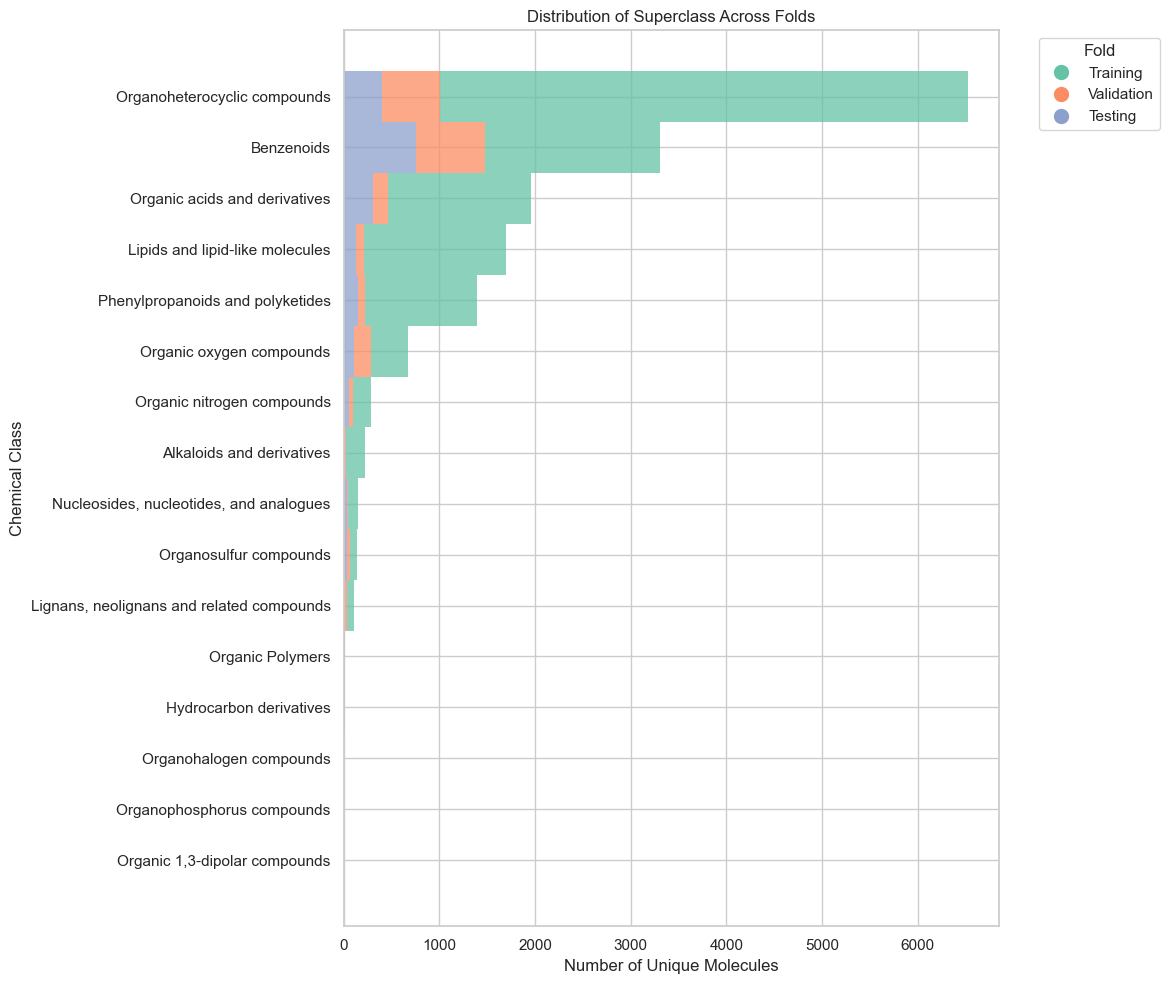

In [17]:
plot_class_distribution(merged_df, 'superclass', top_n=50, output_svg=False)


Value counts for class:
Chemical class
Benzene and substituted derivatives    2666
Other (210 classes)                    1858
Carboxylic acids and derivatives       1746
Prenol lipids                           970
Organooxygen compounds                  673
Azoles                                  662
Indoles and derivatives                 571
Pyridines and derivatives               513
Quinolines and derivatives              512
Diazinanes                              467
Flavonoids                              418
Steroids and steroid derivatives        400
Diazanaphthalenes                       384
Diazines                                352
Piperidines                             326
Organonitrogen compounds                284
Coumarins and derivatives               260
Fatty Acyls                             247
Benzopyrans                             215
Benzimidazoles                          213
Phenol ethers                           212
Peptidomimetics                     

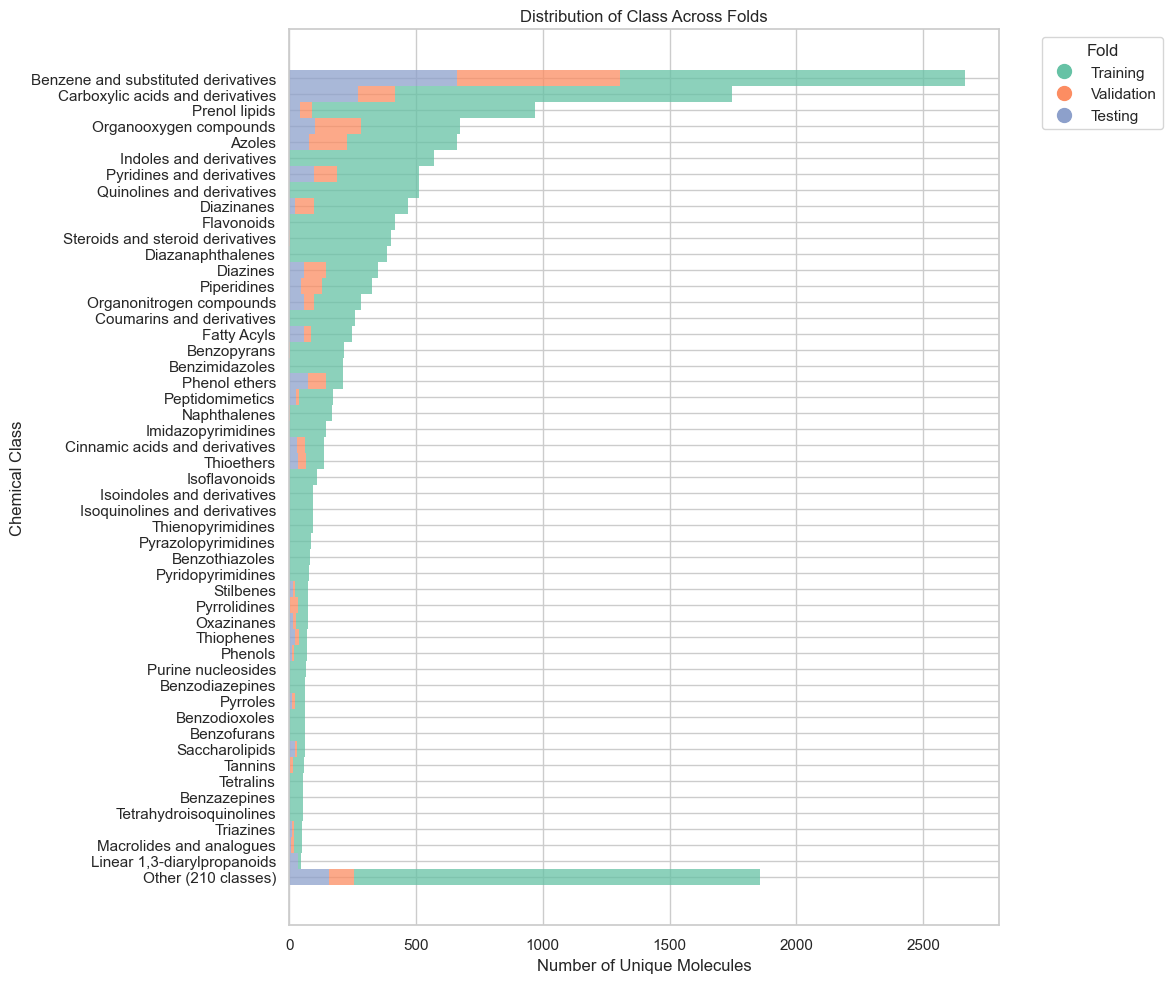

In [18]:
plot_class_distribution(merged_df, 'class', top_n=50, output_svg=False)


Value counts for subclass:
Chemical class
Other (345 classes)                          7135
Amino acids, peptides, and analogues         1581
Benzoic acids and derivatives                 506
Piperazines                                   466
Anilides                                      465
Terpene glycosides                            418
Benzodiazines                                 347
Carbohydrates and carbohydrate conjugates     296
Pyrimidines and pyrimidine derivatives        258
Flavonoid glycosides                          254
Pyrazoles                                     230
Benzenesulfonamides                           213
1-benzopyrans                                 210
Amines                                        207
Carbonyl compounds                            199
Indoles                                       189
Diphenylmethanes                              153
Diterpenoids                                  152
Ethers                                        138
Aryl th

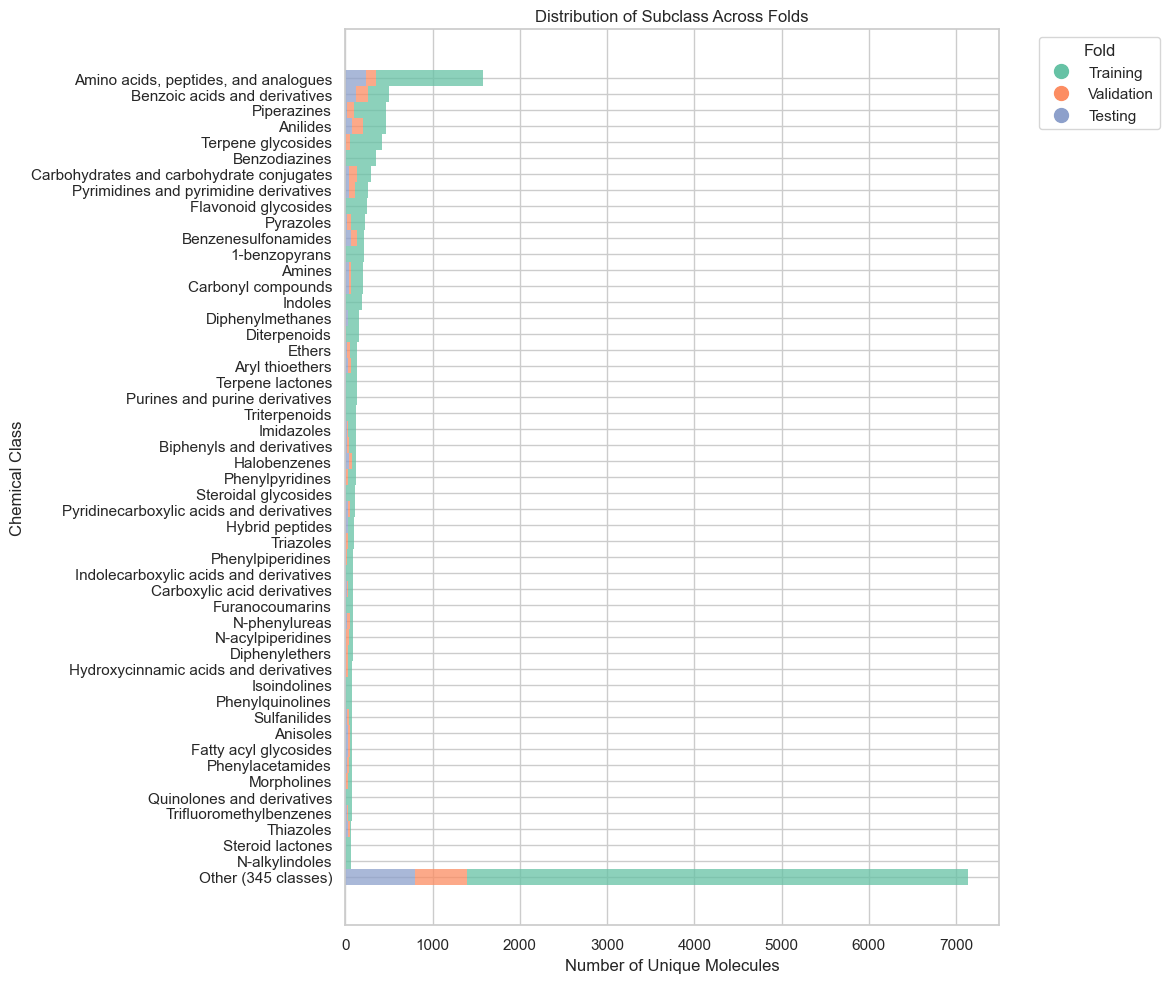

In [19]:
plot_class_distribution(merged_df, 'subclass', top_n=50, output_svg=False)

In [20]:
for classification in classification_levels:
    print(f"\n===== Analysis for {classification.capitalize()} =====")
    analyze_exclusive_classes(merged_df, classification)


===== Analysis for Kingdom =====

=== Exclusive Classes for Kingdom ===
--- Train ---
Num. exclusive classes: 0
Num. exclusive molecules: 0
--- Val ---
Num. exclusive classes: 0
Num. exclusive molecules: 0
--- Test ---
Num. exclusive classes: 0
Num. exclusive molecules: 0

===== Analysis for Superclass =====

=== Exclusive Classes for Superclass ===
--- Train ---
Num. exclusive classes: 2
Num. exclusive molecules: 9
--- Val ---
Num. exclusive classes: 0
Num. exclusive molecules: 0
--- Test ---
Num. exclusive classes: 1
Num. exclusive molecules: 2

===== Analysis for Class =====

=== Exclusive Classes for Class ===
--- Train ---
Num. exclusive classes: 181
Num. exclusive molecules: 4026
--- Val ---
Num. exclusive classes: 2
Num. exclusive molecules: 2
--- Test ---
Num. exclusive classes: 8
Num. exclusive molecules: 13

===== Analysis for Subclass =====

=== Exclusive Classes for Subclass ===
--- Train ---
Num. exclusive classes: 222
Num. exclusive molecules: 3246
--- Val ---
Num. exclu